In [1]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import os


boning_df_resampled = pd.read_csv('boning_df_resampled.csv')
slicing_df_resampled = pd.read_csv('slicing_df_resampled.csv')

2025-05-09 21:16:59.385142: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 21:16:59.518155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746789419.567634    3643 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746789419.581964    3643 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746789419.695338    3643 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# **LSTM-CNN models evaluation**

In [2]:
models = [
    'models/boning_activity_recognition_LSTMCNN.keras', 
    'models/boning_sharpness_classification_LSTMCNN.keras',
    'models/slicing_activity_recognition_LSTMCNN.keras', 
    'models/slicing_sharpness_classification_LSTMCNN.keras'
]


def eval_activity_model(name, model, df):
    X = df.drop(columns=['sharpness', 'Label']).values
    y = df['Label'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.fit_transform(X_test)

    time_steps = X_train_sc.shape[1]
    X_test_nn = X_test_sc.reshape(-1, time_steps, 1)

    print(f"\n===== Dataset: {name.upper()} =====")

    model = load_model(model)
    loss, acc = model.evaluate(X_test_nn, y_test, verbose=0)
    print(f"\nModel `{model}` → Test Loss: {loss:.4f}, Test Acc: {acc*100:.2f}%")

    y_pred_proba = model.predict(X_test_nn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print("\nConfusion Matrix:\n")
    print(cm)
    print("\nClassification Report:\n")
    print(report)


def eval_sharpness_model(name, model, df):
    le = LabelEncoder()
    df['sharpness_enc'] = le.fit_transform(df['sharpness'])
    
    X = df.drop(columns=['sharpness', 'sharpness_enc', 'Label']).values
    y = df['sharpness_enc'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.fit_transform(X_test)

    time_steps = X_train_sc.shape[1]
    X_test_nn = X_test_sc.reshape(-1, time_steps, 1)

    print(f"\n===== Dataset: {name.upper()} =====")

    model = load_model(model)
    loss, acc = model.evaluate(X_test_nn, y_test, verbose=0)
    print(f"\nModel `{model}` → Test Loss: {loss:.4f}, Test Acc: {acc*100:.2f}%")

    y_pred_proba = model.predict(X_test_nn, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print("\nConfusion Matrix:\n")
    print(cm)
    print("\nClassification Report:\n")
    print(report)

In [3]:
eval_activity_model("boning_activity_recgonition", models[0], boning_df_resampled)


===== Dataset: BONING_ACTIVITY_RECGONITION =====


I0000 00:00:1746789435.620413    3643 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5551 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1746789437.493830    3752 cuda_dnn.cc:529] Loaded cuDNN version 90300



Model `<Functional name=functional, built=True>` → Test Loss: 0.2402, Test Acc: 91.28%

Confusion Matrix:

[[13822   470   488    29   600    34]
 [  257 12782    99    27   304    38]
 [  794   284 13346   126   865    26]
 [  104   280   122 14391   526    18]
 [  397   400   347   166 16252   104]
 [  192   281    77    42   436 12485]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     15443
           1       0.88      0.95      0.91     13507
           2       0.92      0.86      0.89     15441
           3       0.97      0.93      0.95     15441
           4       0.86      0.92      0.89     17666
           5       0.98      0.92      0.95     13513

    accuracy                           0.91     91011
   macro avg       0.92      0.91      0.91     91011
weighted avg       0.92      0.91      0.91     91011



In [4]:
eval_activity_model("slicing_activity_recognition", models[2], slicing_df_resampled)


===== Dataset: SLICING_ACTIVITY_RECOGNITION =====

Model `<Functional name=functional_1, built=True>` → Test Loss: 0.5974, Test Acc: 78.52%

Confusion Matrix:

[[13312   114   171     0  1424     9     1     0    29]
 [   20  7434    13     0    68     0     0     0     0]
 [  194   129 12946   116  1643    11     0     0    12]
 [   45    17    36 12762  2160     3     3     0    21]
 [  293    62   413    70 21899   120     8     1    47]
 [  154    26   248     3 10533  5343    23     0    10]
 [   26     5    19     0  1990   128  9042    60     6]
 [   24     9    10     0  2099     0   188  8902    50]
 [  157    28    37     0  4260     2     1   475 10072]]

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     15060
           1       0.95      0.99      0.97      7535
           2       0.93      0.86      0.89     15051
           3       0.99      0.85      0.91     15047
           4       0.48      

In [5]:
eval_sharpness_model("boning_sharpness_classification", models[1], boning_df_resampled)


===== Dataset: BONING_SHARPNESS_CLASSIFICATION =====

Model `<Functional name=functional_2, built=True>` → Test Loss: 0.4865, Test Acc: 82.40%

Confusion Matrix:

[[ 9947   146    17     8    47   449    40   929]
 [  111  6613   149     2    56   554     0   238]
 [  109   102 10003   306    41   411     3   607]
 [   15     8   198  9214   366  1001     7   766]
 [    9     4     3   103  9368  1487    12   567]
 [   13     4     4     8   431 11353   251  1390]
 [   60     1     0     2   126   814  9355  1222]
 [  179     7     2     4   275  2112   244  9138]]

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     11583
           1       0.96      0.86      0.91      7723
           2       0.96      0.86      0.91     11582
           3       0.96      0.80      0.87     11575
           4       0.87      0.81      0.84     11553
           5       0.62      0.84      0.72     13454
           6       0.94

In [6]:
eval_sharpness_model("slicing_sharpness_classfication", models[3], slicing_df_resampled)


===== Dataset: SLICING_SHARPNESS_CLASSFICATION =====

Model `<Functional name=functional_3, built=True>` → Test Loss: 0.4993, Test Acc: 78.42%

Confusion Matrix:

[[24408  1658  2542  1423]
 [  931 26954  5124  4232]
 [  226  4269 24423  4437]
 [  214   945  1956 25794]]

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     30031
           1       0.80      0.72      0.76     37241
           2       0.72      0.73      0.72     33355
           3       0.72      0.89      0.80     28909

    accuracy                           0.78    129536
   macro avg       0.79      0.79      0.79    129536
weighted avg       0.79      0.78      0.79    129536



# **Random Forest Classification**

### Boning/Slicing classification

### Activity/Sharpness classification

# **Random Forest Evaluation**

In [7]:
boning_df_resampled.head()

,Unnamed: 0,Left Forearm_mean,Left Forearm_std,Left Forearm_min,Left Forearm_max,Left Forearm_AUC,Left Forearm_peaks,Left Hand_mean,Left Hand_std,Left Hand_min,...,T12_peaks,Right Upper Arm_mean,Right Upper Arm_std,Right Upper Arm_min,Right Upper Arm_max,Right Upper Arm_AUC,Right Upper Arm_peaks,Label,sharpness,sharpness_enc
0,0,1.876409,2.051621,1.078288,1.630207,0.853869,0.115729,1.827531,1.862688,0.955199,...,0.246344,1.111297,0.812571,0.720618,0.789062,0.741382,-0.615305,4,87,5
1,1,1.080936,0.999520,0.075243,0.768001,1.048697,0.222120,0.541707,0.551566,0.106542,...,-0.508336,0.196462,0.360562,0.195400,0.213189,0.713007,-0.032592,3,90,7
2,2,-0.364082,-0.330881,-0.374467,-0.368047,0.461554,0.037417,-0.318049,-0.269953,-0.315857,...,0.942781,-0.255639,-0.289346,-0.252028,-0.275853,0.083707,1.025952,4,90,7
3,3,1.159191,0.791470,0.642977,0.808265,0.759329,0.659650,1.774102,1.195944,1.711779,...,0.844894,-0.096459,-0.082979,-0.081893,-0.110447,-0.538301,0.565767,1,90,7
4,4,0.941461,1.062366,0.843522,0.873362,0.676626,-0.371386,1.644135,1.451736,0.553069,...,0.033493,1.963693,0.885662,1.461168,1.320238,-0.579347,0.997880,4,79,4


In [45]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def activity_sensor_analysis(df, label_col='Label', test_size=0.2, random_state=42):
    df = df.drop(['Unnamed: 0', 'sharpness', 'sharpness_enc'], axis=1)
    
    feature_cols = [c for c in df.columns if c != label_col]
    sensors = sorted({col.split('_', 1)[0] for col in feature_cols})

    results = {}

    X = df.drop(columns=[label_col]).values
    y = df[label_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    clf = RandomForestClassifier(n_estimators=10, random_state=random_state, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results['ALL'] = accuracy_score(y_test, y_pred)

    for sensor in sensors:
        drop_cols = [c for c in df.columns if c.startswith(sensor + '_')]
        df_reduced = df.drop(columns=drop_cols)

        Xr = df_reduced.drop(columns=[label_col]).values
        yr = df_reduced[label_col].values

        X_tr, X_te, y_tr, y_te = train_test_split(
            Xr, yr, test_size=test_size, stratify=yr, random_state=random_state
        )

        clf = RandomForestClassifier(n_estimators=10, random_state=random_state, n_jobs=-1)
        clf.fit(X_tr, y_tr)
        y_pr = clf.predict(X_te)
        results[sensor] = accuracy_score(y_te, y_pr)

    return results, ['ALL'] + sensors

def plot_sensor(results, sensor_list, padding=0.002):
    # 1) Gather keys, labels, and accuracies
    keys = list(results.keys())
    accuracies = [results[k] for k in keys]

    # Turn each key into a human-readable label:
    labels = []
    for k in keys:
        if isinstance(k, tuple):
            labels.append('+'.join(k))
        else:
            labels.append(str(k))

    # 2) Compute baseline (first entry) and zoom limits
    baseline = accuracies[0]
    ymin, ymax = min(accuracies), max(accuracies)
    yrange = ymax - ymin
    y_low  = ymin - padding * yrange
    y_high = ymax + padding * yrange

    # 3) Plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, accuracies, color='C0')
    plt.axhline(baseline, color='C1', linestyle='--', label='Baseline (ALL)')
    
    # Zoom y-axis
    plt.ylim(y_low, y_high)
    
    plt.xticks(rotation=90)
    plt.ylabel('Accuracy')
    plt.title('Leave-Sensor-Out Random Forest Accuracy (Zoomed)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
results, sensor_list = activity_sensor_analysis(boning_df_resampled)

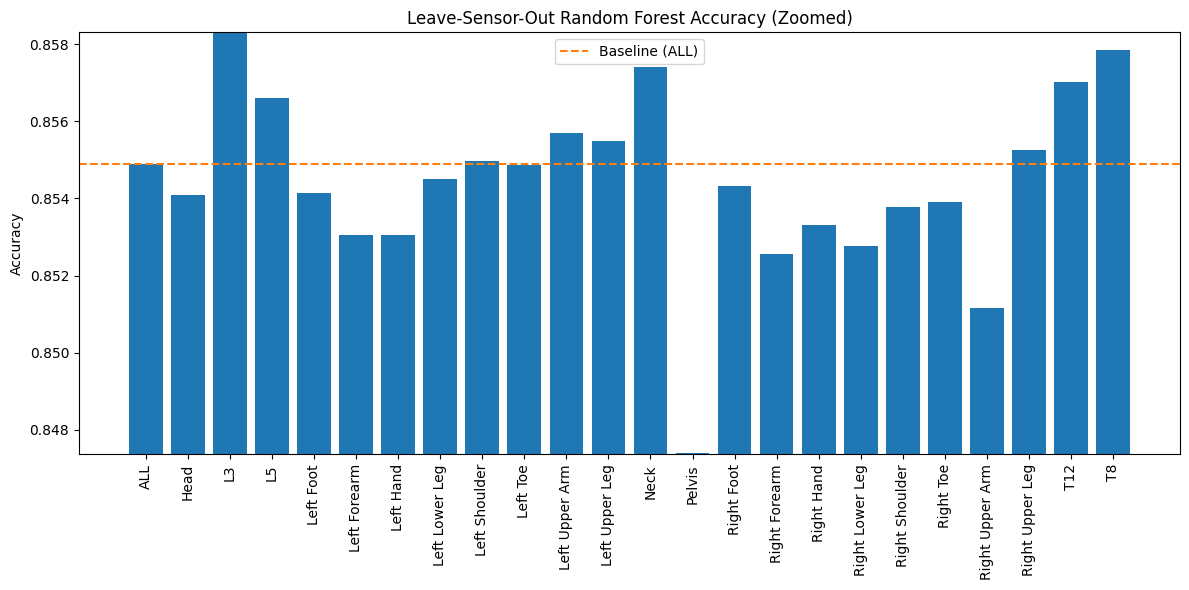

In [47]:
plot_sensor(results, sensor_list)

In [37]:
from itertools import combinations

def eval_rf_accuracy(df, drop_sensors, label_col='Label',
                     test_size=0.2, random_state=42, n_estimators=100):
    """
    Drop all sensors in `drop_sensors` (list of sensor‐name prefixes),
    train a RandomForest on the remainder, and return test accuracy.
    """
    df = df.drop(['Unnamed: 0', 'sharpness', 'sharpness_enc'], axis=1)
    
    df2 = df.copy()
    # drop all columns whose prefix is in drop_sensors
    for sensor in drop_sensors:
        cols = [c for c in df2.columns if c.startswith(sensor + '_')]
        df2.drop(columns=cols, inplace=True)
    X = df2.drop(columns=[label_col]).values
    y = df2[label_col].values

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    ).fit(Xtr, ytr)
    return accuracy_score(yte, clf.predict(Xte))


def leave_sensor_groups_out_analysis(
    df,
    sensor_groups,
    label_col='Label',
    test_size=0.2,
    random_state=42,
    n_estimators=100
):
    """
    sensor_groups: list of tuples, where each tuple is one or more sensor names to drop.
    e.g.  [('L3','L5'),
           ('Left Foot','Left Lower Leg','Left Upper Leg','Left Toe'),
           ...]
    """
    # 1) Baseline (drop none)
    results = {('ALL',): eval_rf_accuracy(
        df,
        drop_sensors=[],
        label_col=label_col,
        test_size=test_size,
        random_state=random_state,
        n_estimators=n_estimators
    )}

    # 2) For each group, drop them and record accuracy
    for group in sensor_groups:
        results[group] = eval_rf_accuracy(
            df,
            drop_sensors=list(group),
            label_col=label_col,
            test_size=test_size,
            random_state=random_state,
            n_estimators=n_estimators
        )

    return results


def plot_leave_out_groups(results, padding=0.002):
    """
    Bar‐plot accuracy for each drop‐group in results dict.
    Keys are tuples of sensor names (or ('ALL',) for baseline).
    """
    labels = []
    accs   = []
    for key, acc in results.items():
        labels.append('ALL' if key==('ALL',) else '+'.join(key))
        accs.append(acc)

    baseline = accs[0]
    ymin, ymax = min(accs), max(accs)
    yrange = ymax - ymin
    # add a little headroom
    y_low  = ymin - padding*yrange
    y_high = ymax + padding*yrange

    plt.figure(figsize=(12,5))
    plt.bar(labels, accs, color='C0')
    plt.axhline(baseline, color='C1', linestyle='--', label='Baseline (ALL)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(y_low, y_high)
    plt.ylabel('Accuracy')
    plt.title('Leave-One/More-Sensor-Out RF Accuracy (Zoomed)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [30]:
print(sensor_list)

['ALL', 'Head', 'L3', 'L5', 'Left Foot', 'Left Forearm', 'Left Hand', 'Left Lower Leg', 'Left Shoulder', 'Left Toe', 'Left Upper Arm', 'Left Upper Leg', 'Neck', 'Pelvis', 'Right Foot', 'Right Forearm', 'Right Hand', 'Right Lower Leg', 'Right Shoulder', 'Right Toe', 'Right Upper Arm', 'Right Upper Leg', 'T12', 'T8']


In [39]:
# 1) Define specific proximal sensor pairs you want to test:
sensor_groups = [
    ('L3', 'L5'),
    ('Left Toe', 'Left Lower Leg', 'Left Upper Leg', 'Left Foot'), # Left leg area
    ('Right Toe', 'Right Lower Leg', 'Right Upper Leg', 'Right Foot'), # Right Leg area
    ('Left Forearm', 'Left Upper Arm', 'Left Hand'),
    ('Right Forearm', 'Right Upper Arm', 'Right Hand'),
    ('T12', 'T8'),
    ('L3', 'L5', 'T12', 'T8', 'Right Toe', 'Left Toe', 'Left Forearm', 'Right Forearm', 'Left Upper Leg', 'Right Upper Leg', 'Left Lower Leg', 'Right Lower Leg'),
    # add more pairs as needed...
]

# 2) Run analysis only on those pairs:
results = leave_sensor_groups_out_analysis(
    boning_df_resampled,
    label_col='Label',
    sensor_groups=sensor_groups,
    n_estimators=10
)

/tmp/ipykernel_3643/3856166968.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


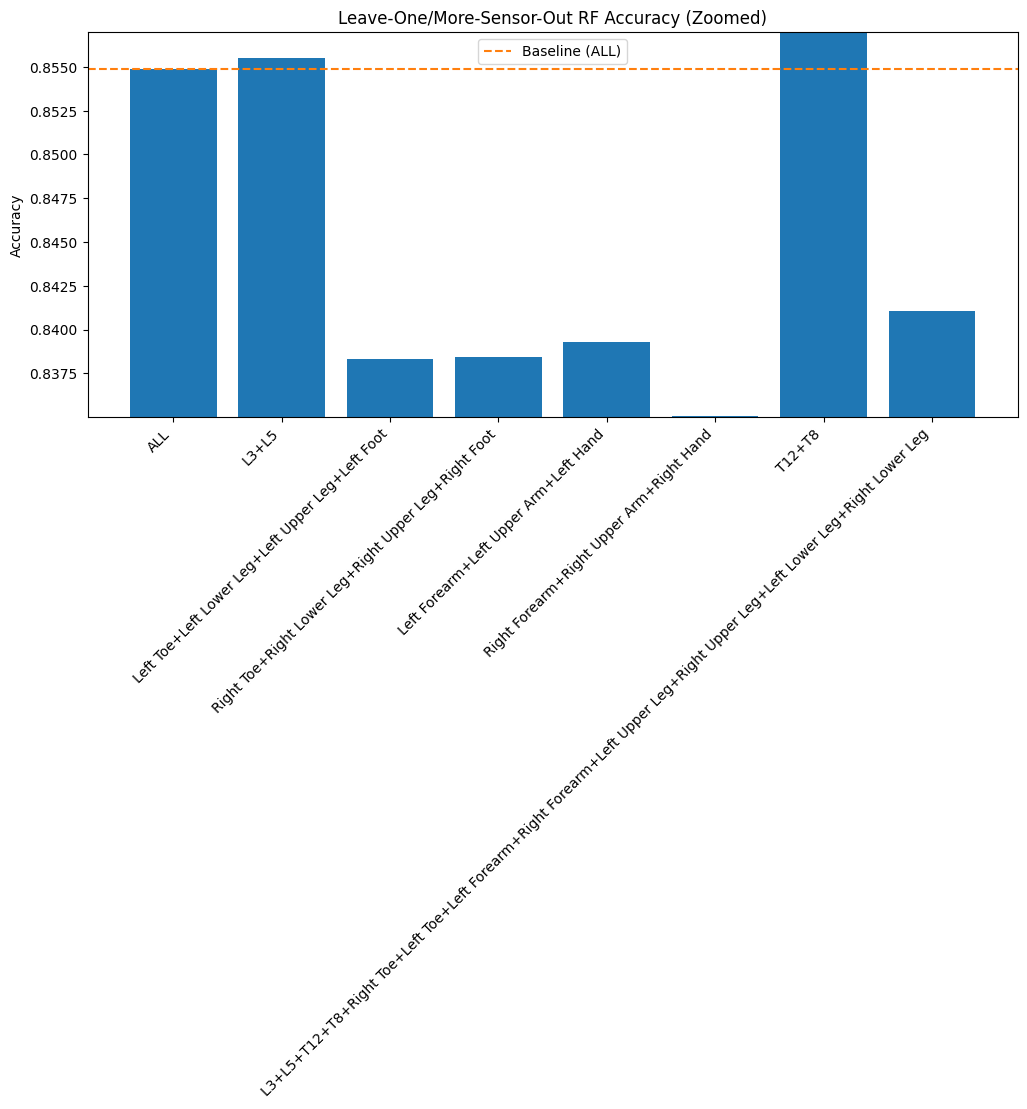

In [38]:
plot_leave_out_groups(results)